In [1]:
import sys
import re
import segyio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import hilbert

sys.path.append('..')
  
from seismicpro.src import FieldIndex, SeismicBatch, SeismicDataset, seismic_plot, CustomIndex
from seismicpro.src.seismic_metrics import MetricsMap, PM, SemblanceMetrics
from seismicpro.batchflow import I, V, B, Pipeline, R, P

from datasets.paths import *

In [2]:
index_good = FieldIndex(name='raw', path='/data/PROD/Vaysky_mute_eq.sgy', markup_path='/data/PROD/Vaysky_pickingWZ.csv', 
                   extra_headers=['offset', 'GroupX', 'GroupY', 'SourceX', 'SourceY'])#, 'ReceiverGroupElevation', 'SourceSurfaceElevation', 'SourceMeasurementMantissa', 'SourceWaterDepth'])
# index_bad = FieldIndex(name='raw', path=path, markup_path='/data/PROD/Vaysky_picking.csv', 
#                    extra_headers=['offset', 'GroupX', 'GroupY', 'SourceX', 'SourceY', 'ReceiverDatumElevation'])

In [3]:
index_good.head()

,offset,GroupX,SourceY,TraceNumber,SourceX,GroupY,FIRST_BREAK_TIME,TRACE_SEQUENCE_FILE,file_id
,,,,,,,,raw,raw
FieldRecord,,,,,,,,,
70,-79,4665755,66053770,1656,4666003,66053020,108.0,1,/data/PROD/Vaysky_mute_eq.sgy
70,1619,4681749,66053770,1544,4666003,66050020,1044.0,552,/data/PROD/Vaysky_mute_eq.sgy
70,1621,4680744,66053770,1398,4666003,66047025,1048.0,553,/data/PROD/Vaysky_mute_eq.sgy
70,1621,4673750,66053770,2392,4666003,66068010,1048.0,554,/data/PROD/Vaysky_mute_eq.sgy
70,-1622,4651260,66053770,1339,4666003,66047015,1056.0,555,/data/PROD/Vaysky_mute_eq.sgy


In [3]:
df = index_good._idf
df.offset = abs(df.offset)
#df = df[df['SourceMeasurementMantissa'] > 0]

In [4]:
df['CMPX'], df['CMPY'] = (df.GroupX + df.SourceX) // 2, (df.GroupY + df.SourceY) // 2

In [5]:
# df = df.groupby(level=0)
# df = df.apply( lambda _df : _df.iloc[slice(0, 1000)])
# df.index = df.index.droplevel()

In [6]:
index_good._idf = df

In [7]:
# index_good._idf.GroupX = index_good._idf.GroupX / 10
# index_good._idf.GroupY = index_good._idf.GroupY / 10
# index_good._idf.SourceY = index_good._idf.SourceY / 10
# index_good._idf.SourceX = index_good._idf.SourceX / 10

In [8]:
dataset = SeismicDataset(index_good)

In [10]:
index_good.head()

,offset,GroupX,SourceY,TraceNumber,SourceX,GroupY,FIRST_BREAK_TIME,TRACE_SEQUENCE_FILE,file_id,CMPX,CMPY
,,,,,,,,raw,raw,,
FieldRecord,,,,,,,,,,,
70,79,4665755,66053770,1656,4666003,66053020,108.0,1,/data/PROD/Vaysky_mute_eq.sgy,4665879,66053395
70,1619,4681749,66053770,1544,4666003,66050020,1044.0,552,/data/PROD/Vaysky_mute_eq.sgy,4673876,66051895
70,1621,4680744,66053770,1398,4666003,66047025,1048.0,553,/data/PROD/Vaysky_mute_eq.sgy,4673373,66050397
70,1621,4673750,66053770,2392,4666003,66068010,1048.0,554,/data/PROD/Vaysky_mute_eq.sgy,4669876,66060890
70,1622,4651260,66053770,1339,4666003,66047015,1056.0,555,/data/PROD/Vaysky_mute_eq.sgy,4658631,66050392


In [33]:
pipeline = (dataset.p
            .add_namespace(PM)
            .init_variable('metrics')
            .init_variable('metrics1')
            .load(fmt='segy', components='raw')
            .load(fmt='index', 
                  components=('offset', 'TraceNumber', 'GroupX', 'GroupY', 'SourceX', 'SourceY', 'CMPX', 'CMPY'), #, 'GroupElevation', 'SourceElevation'), # picking
                  src=('offset', 'TraceNumber', 'GroupX', 'GroupY', 'SourceX', 'SourceY', 'CMPX', 'CMPY'))#, 'ReceiverGroupElevation', 'SourceSurfaceElevation')) # SourceMeasurementMantissa
            .load(fmt='picks', components='picking')
            .velocity(B(), dst='diff')
            .gather_metrics(MetricsMap, metrics=B('diff'),
                            coords=B('index').get_df()[["CMPX", 'CMPY']].values,
                            save_to=V('metrics', mode='a'))
#            .gather_metrics(MetricsMap, metrics=B('diff_elev'),
#                             coords=B('index').get_df()[["SourceX", "SourceY"]],
#                             save_to=V('metrics1', mode='a'))
            .run_later(256, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

In [28]:
batch = pipeline.next_batch(3)

cv = 10000
xlim = (0, 400)
ylim = (0, 400)

pts = (range(len(batch.picking[0])), batch.picking[0] // 2)
seismic_plot(batch.raw[0], figsize=(15, 5), cmap='gray', vmax=cv, vmin=-cv, xlim=xlim, ylim=ylim, pts=pts, wiggle=False)
analytic = hilbert(batch.raw[0])
phase = np.angle(analytic)
#phase = np.unwrap(np.angle(analytic))
#phase = phase % (2 * np.pi) - np.pi
phase_along_pick = [] 
for i, pick in enumerate(batch.picking[0]):
    phase_along_pick.append(phase[i][int(pick//2)])

plt.figure(figsize=(15 ,5))
phase_along_pick = phase_along_pick[slice(*xlim)]
plt.scatter(range(len(phase_along_pick)), phase_along_pick, s=10)

In [ ]:
badd = np.where(np.abs(phase_along_pick) > 1.5)[0]

for i in badd:
    bad = [i - 3, i -2, i - 1, i, i + 1, i + 2]
    pts = (range(len(batch.picking[0][bad])) ,batch.picking[0][bad] // 2)
    plt.figure(figsize=(15,5))
    phase_along_pick = np.array(phase_along_pick)
    ylim = (batch.picking[0][i] // 2 - 100, batch.picking[0][i] // 2 + 100)
    seismic_plot(batch.raw[0][bad], cmap='gray', wiggle=True, 
                 figsize=(15, 5), std=0.1, pts=pts, scatter_color='r', s=30, ylim=ylim)

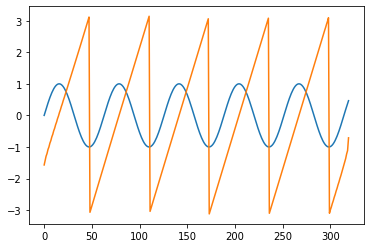

In [199]:
import scipy
signal = np.sin(np.arange(0, ., 0.1))
plt.plot(signal)
plt.plot(np.angle(scipy.signal.hilbert(signal)))

In [ ]:
pipeline.run()

In [ ]:
metrics = pipeline.v('metrics')
mean_metrics = metrics.evaluate('map', bin_size=10, figsize=(10, 7), save_dir=None, pad=True, max_value=20)
#print('Mean value of metrics: {:.3}'.format(mean_ametrics))

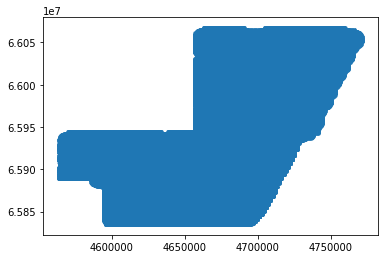

In [47]:
plt.scatter(index_good._idf.CMPX.values, index_good._idf.CMPY.values, s=1)

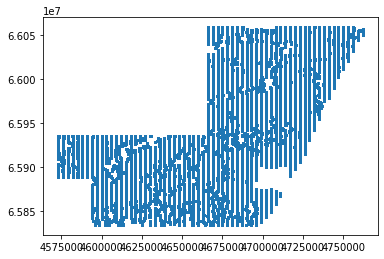

In [48]:
plt.scatter(index_good._idf.SourceX.values, index_good._idf.SourceY.values, s=1)

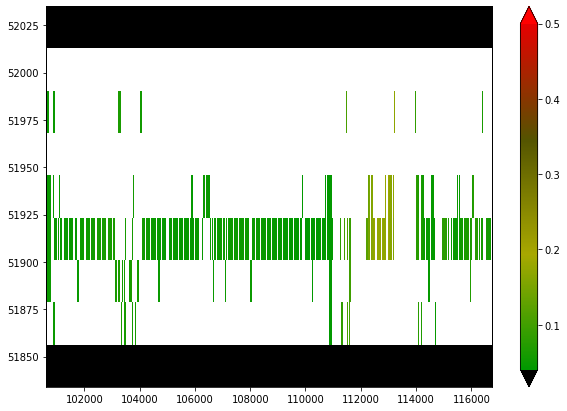

Mean value of metrics: 0.0652


In [145]:
metrics = pipeline.v('metrics1')
mean_metrics = metrics.evaluate('map', bin_size=40, figsize=(10, 7), save_dir=None, pad=True, max_value=0.5)
print('Mean value of metrics: {:.3}'.format(mean_metrics))